In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from kagglehub import KaggleDatasetAdapter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

## Set the path to the file you'd like to load

In [41]:
file_path = "car data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "vijayaadithyanvg/car-price-predictionused-cars",
  file_path,
)

/tmp/ipython-input-41-907080690.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


In [42]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Driven_kms,Fuel_Type,Selling_type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


#Basic Preprocessing

In [43]:
import datetime
current_year = datetime.datetime.now().year
df['Car_Age'] = current_year - df['Year']

df.drop(['Year', 'Car_Name'], axis=1, inplace=True)


#Handle Categorical Variables
Use `ColumnTransformer` with `OneHotEncoder` for:
* `Fuel_Type`
* `Selling_type`
* `Transmission`



##Define Features and Target

In [44]:
X = df.drop('Selling_Price', axis=1)
y = df['Selling_Price']

categorical_features = ['Fuel_Type', 'Selling_type', 'Transmission']
numerical_features = ['Present_Price', 'Driven_kms', 'Owner', 'Car_Age']

# ColumnTransformer
from sklearn.compose import make_column_transformer

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first'), categorical_features),
    remainder='passthrough'  # keep numeric features
)

#Model Pipeline

In [45]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, min_samples_leaf = 2, n_estimators= 250))
])

#Train-Test Split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Train the Model

In [47]:
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Fuel_Type', 'Selling_type',
                                                   'Transmission'])])),
                ('regressor',
                 RandomForestRegressor(min_samples_leaf=2, n_estimators=250,
                                       random_state=42))])

#Make Predictions and Evaluate

In [48]:
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: 0.9585537728345512
Mean Absolute Error: 0.6291982755186522
RMSE: 0.9771069894933944


#Visualize Results

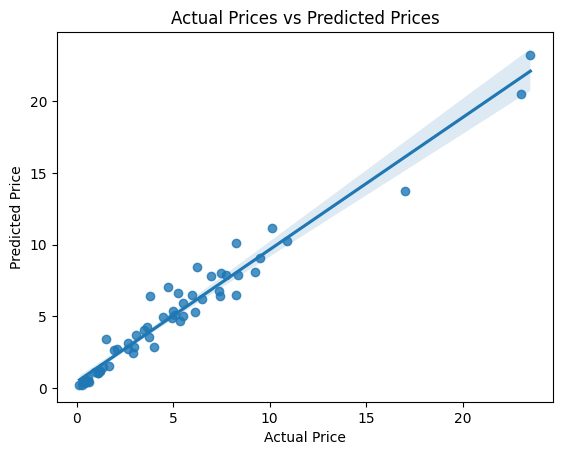

In [49]:
sns.regplot(x=y_test, y=y_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Prices vs Predicted Prices")
plt.show()

In [50]:
pred_df=pd.DataFrame({'Actual Price':y_test,'Predicted Price':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Price,Predicted Price,Difference
177,0.35,0.416753,-0.066753
289,10.11,11.156430,-1.046430
228,4.95,4.897710,0.052290
198,0.15,0.221958,-0.071958
60,6.95,7.790751,-0.840751
...,...,...,...
234,5.50,5.039717,0.460283
296,9.50,9.078654,0.421346
281,2.10,2.756811,-0.656811
285,7.40,6.758761,0.641239


Feature Importances:


,0
Present_Price,8.990684e-01
Car_Age,5.511197e-02
Driven_kms,3.461208e-02
Transmission_Manual,3.329108e-03
Fuel_Type_Diesel,2.969398e-03
Fuel_Type_Petrol,2.636189e-03
Selling_type_Individual,2.272211e-03
Owner,6.380875e-07


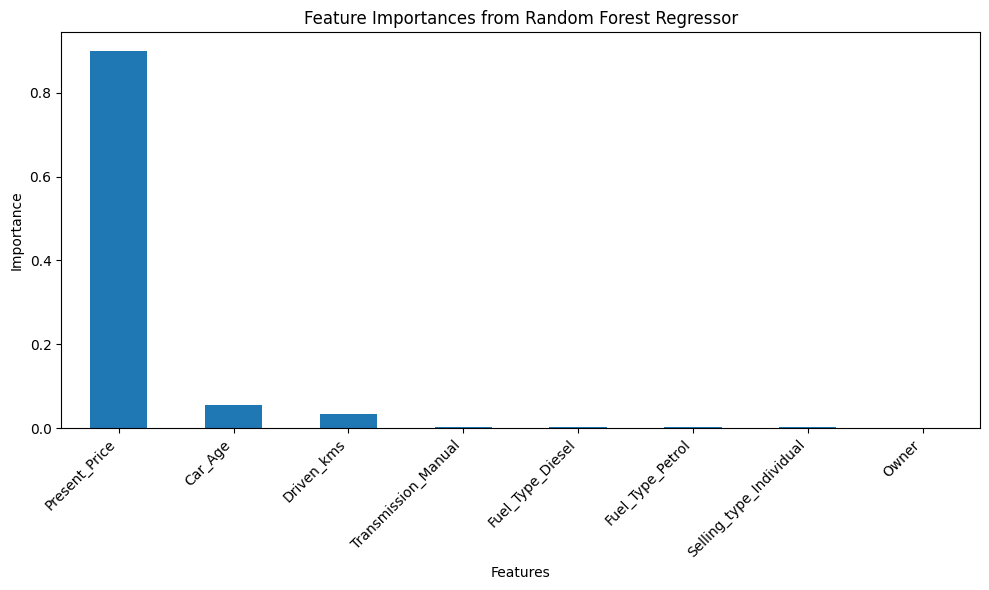

In [51]:
# Access the trained regressor from the pipeline
regressor_model = model.named_steps['regressor']

# Get feature importances
feature_importances = regressor_model.feature_importances_

# Get feature names after one-hot encoding
# The order of features matches the order in the preprocessor
# The first features are the one-hot encoded categorical features, then the remainder numerical features
ohe_feature_names = model.named_steps['preprocessor'].named_transformers_['onehotencoder'].get_feature_names_out(categorical_features)
all_feature_names = list(ohe_feature_names) + numerical_features

# Create a pandas Series for better visualization
feature_importance_series = pd.Series(feature_importances, index=all_feature_names)

# Sort and display feature importances
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)
print("Feature Importances:")
display(sorted_feature_importances)

# Optional: Visualize feature importances
plt.figure(figsize=(10, 6))
sorted_feature_importances.plot(kind='bar')
plt.title('Feature Importances from Random Forest Regressor')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#Test XGBoost for Better Accuracy

In [52]:
from xgboost import XGBRegressor

model_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42))
])

model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

print("XGBoost R² Score:", r2_score(y_test, y_pred_xgb))
print("XGBoost Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

XGBoost R² Score: 0.9476107863043174
XGBoost Mean Absolute Error: 0.6291982755186522
XGBoost RMSE: 0.9771069894933944
